In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pyabc import *

settings.set_figure_params("pyabc")  # for beautified plots

rng = np.random.default_rng()

from simulations.elastic_collisions import (
    Body,
    Variables,
    ElasticCollisionSimulation,
    HiddenVariables,
)
import torch

# simulation parameters
total_time = 1.0
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)
num_bodies = 1
VARIABLES = Variables(
    masses=torch.full((num_bodies,), constant_mass_value),
    radii=torch.full((num_bodies,), constant_radius_value),
    starting_positions=None,
    num_bodies=num_bodies,
    space_size=torch.tensor([space_size, space_size]),
    acceleration_coefficients=torch.Tensor([1.0] * num_bodies),
    initial_velocities=None,
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(
    VARIABLES, position_distribution
)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(
    sample_shape=torch.Size([num_bodies, 2])
)
print(f"initial_velocities: {initial_velocities}")

SIMULATION = ElasticCollisionSimulation(VARIABLES, enable_logging=False, noise=False)

hidden_variables = HiddenVariables(
    masses=None,
    radii=None,
    num_bodies=None,
    acceleration_coefficients=None,
    initial_velocities=initial_velocities,
)

result = SIMULATION.simulate(
    hidden_variables=hidden_variables, total_time=total_time, dt=dt
)

print(f"result: {result}")


def model(p):
    starting_velocities = torch.tensor(
        [[p["X0"], p["Y0"]]], dtype=torch.float32
    )
    X_Obs = SIMULATION.simulate(
        hidden_variables=HiddenVariables(
            masses=VARIABLES.masses,
            radii=VARIABLES.radii,
            num_bodies=VARIABLES.num_bodies,
            acceleration_coefficients=None,
            initial_velocities=starting_velocities,
        ),
        total_time=total_time,
        dt=dt,
    )
    # convert to numpy array
    X_Obs = X_Obs.detach().numpy()
    return {"X_Obs": X_Obs}


# true parameters
true_parameters = {
    "X0": initial_velocities[0, 0].item(),
    "Y0": initial_velocities[0, 1].item(),
}

# prior
prior = Distribution(
    X0=RV("uniform", -5, 5),
    Y0=RV("uniform", -5, 5),
)

# observed data
# X_Obs = result.detach().numpy()
# without np
X_Obs = {"X_Obs": result.detach().numpy()}


# distance function
def distance(x, y):
    return np.linalg.norm(x["X_Obs"] - y["X_Obs"])


# parameter bounds
prior_bounds = {
    "X0": (-5, 5),
    "Y0": (-5, 5),
}




initial_positions: tensor([[8.6608, 4.4951]])
initial_velocities: tensor([[0.0873, 0.3469]])
result: tensor([[8.7481, 4.8420]])


In [4]:
# ABCSMC
abc = ABCSMC(model, prior, distance, population_size=1000)
abc.new(create_sqlite_db_id(), X_Obs)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)

ABC.Sampler INFO: Parallelize sampling on 24 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2024-03-25 12:27:52>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.94567204e+00.
ABC INFO: Accepted: 1000 / 1949 = 5.1308e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.04292154e+00.
ABC INFO: Accepted: 1000 / 3580 = 2.7933e-01, ESS: 8.5481e+02.
ABC INFO: t: 2, eps: 5.39678326e+00.
ABC INFO: Accepted: 1000 / 5481 = 1.8245e-01, ESS: 7.1882e+02.
ABC INFO: t: 3, eps: 4.90898762e+00.
ABC INFO: Accepted: 1000 / 9272 = 1.0785e-01, ESS: 6.3753e+02.
ABC INFO: t: 4, eps: 4.54503923e+00.
ABC INFO: Accepted: 1000 / 14896 = 6.7132e-02, ESS: 6.1316e+02.
ABC INFO: t: 5, eps: 4.23815587e+00.
ABC INFO: Accepted: 1000 / 23910 = 4.1824e-02, ESS: 6.7912e+02.
ABC INFO: t: 6, eps: 3.99027606e+00.
ABC INFO: Accepted: 1000 / 41754 = 2.3950e-02, ESS: 4.9749e+02.
ABC INFO: t: 7, eps: 3.77123225e+00.
ABC INFO: Accepted: 1000 / 75866 = 1.3181e-02, ESS: 4.9742e+02.
ABC INFO: t: 8, eps: 3.54511133e+

/home/ubuntu/Documents/GNN/GNN_Project/.venv/lib/python3.10/site-packages/pyabc/transition/base.py:118: RuntimeWarning: divide by zero encountered in log
  return (np.log(densities) * w).sum()
/home/ubuntu/Documents/GNN/GNN_Project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf]
  warnings.warn(
/home/ubuntu/Documents/GNN/GNN_Project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1062: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.525}
/home/ubuntu/Documents/GNN/GNN_Project/.venv/lib/python3.10/site-packages/pyabc/transition/base.py:118: RuntimeWarning: divide by zero encountered in log
  return (np.log(densities) * w).sum()
/home/ubuntu/Documents/GNN/GNN_Project/.venv/lib/pyt

array([[<Axes: ylabel='X0'>, <Axes: >],
       [<Axes: xlabel='X0', ylabel='Y0'>, <Axes: xlabel='Y0'>]],
      dtype=object)

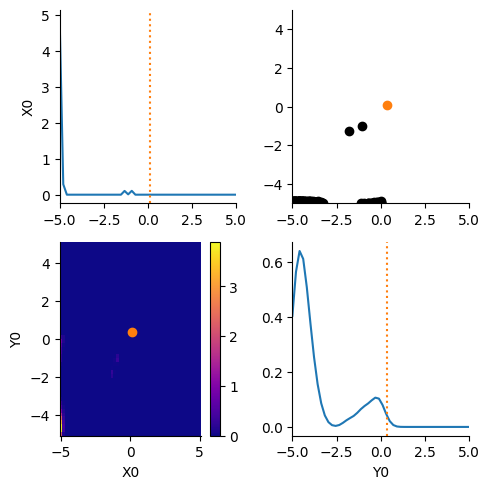

In [5]:
# visualize results
visualization.plot_kde_matrix_highlevel(
    history,
    limits=prior_bounds,
    refval=true_parameters,
    kde=GridSearchCV(),
)

<Axes: xlabel='X0', ylabel='Y0'>

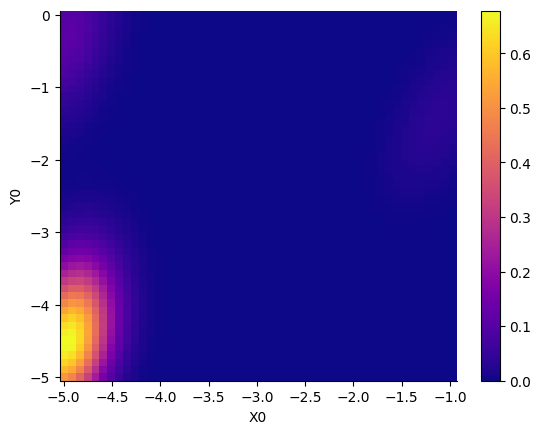

In [6]:
# visualize results
visualization.plot_kde_2d_highlevel(
    history,
    x="X0",
    y="Y0",
)

<Axes: xlabel='X0', ylabel='Posterior'>

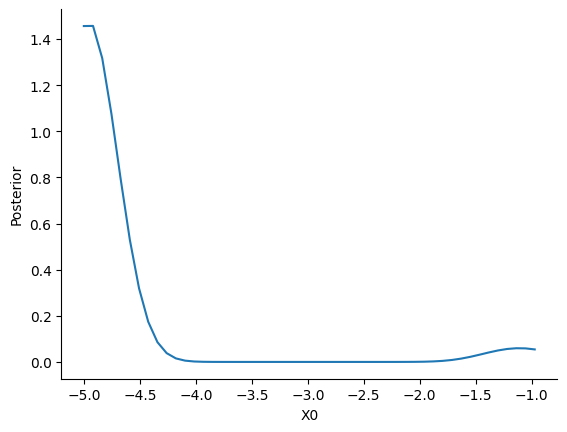

In [7]:
visualization.plot_kde_1d_highlevel(
    history,
    x="X0",
)

## With 2 bodies:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from pyabc import *

settings.set_figure_params("pyabc")  # for beautified plots

rng = np.random.default_rng()

from simulations.elastic_collisions import (
    Body,
    Variables,
    ElasticCollisionSimulation,
    HiddenVariables,
)
import torch

# simulation parameters
total_time = 1.0
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)
num_bodies = 2
VARIABLES = Variables(
    masses=torch.full((num_bodies,), constant_mass_value),
    radii=torch.full((num_bodies,), constant_radius_value),
    starting_positions=None,
    num_bodies=num_bodies,
    space_size=torch.tensor([space_size, space_size]),
    acceleration_coefficients=torch.Tensor([1.0] * num_bodies),
    initial_velocities=None,
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(
    VARIABLES, position_distribution
)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(
    sample_shape=torch.Size([num_bodies, 2])
)
print(f"initial_velocities: {initial_velocities}")

SIMULATION = ElasticCollisionSimulation(VARIABLES, enable_logging=False, noise=False)

hidden_variables = HiddenVariables(
    masses=None,
    radii=None,
    num_bodies=None,
    acceleration_coefficients=None,
    initial_velocities=initial_velocities,
)

result = SIMULATION.simulate(
    hidden_variables=hidden_variables, total_time=total_time, dt=dt
)

print(f"result: {result}")


def model(p):
    starting_velocities = torch.tensor(
        [[p["X0"], p["Y0"]], [p["X1"], p["Y1"]]], dtype=torch.float32
    )
    X_Obs = SIMULATION.simulate(
        hidden_variables=HiddenVariables(
            masses=VARIABLES.masses,
            radii=VARIABLES.radii,
            num_bodies=VARIABLES.num_bodies,
            acceleration_coefficients=None,
            initial_velocities=starting_velocities,
        ),
        total_time=total_time,
        dt=dt,
    )
    # convert to numpy array
    X_Obs = X_Obs.detach().numpy()
    return {"X_Obs": X_Obs}


# true parameters
true_parameters = {
    "X0": initial_velocities[0, 0].item(),
    "Y0": initial_velocities[0, 1].item(),
    "X1": initial_velocities[1, 0].item(),
    "Y1": initial_velocities[1, 1].item(),
}

# prior
prior = Distribution(
    X0=RV("uniform", -5, 5),
    Y0=RV("uniform", -5, 5),
    X1=RV("uniform", -5, 5),
    Y1=RV("uniform", -5, 5),
)

# observed data
# X_Obs = result.detach().numpy()
# without np
X_Obs = {"X_Obs": result.detach().numpy()}


# distance function
def distance(x, y):
    return np.linalg.norm(x["X_Obs"] - y["X_Obs"])


# parameter bounds
prior_bounds = {
    "X0": (-5, 5),
    "Y0": (-5, 5),
    "X1": (-5, 5),
    "Y1": (-5, 5),
}

initial_positions: tensor([[1.5198, 1.5484],
        [3.6633, 7.3314]])
initial_velocities: tensor([[2.8164, 2.0895],
        [1.5398, 0.4420]])
result: tensor([[4.3362, 3.6379],
        [5.2031, 7.7734]])


In [9]:
# ABCSMC
abc = ABCSMC(model, prior, distance, population_size=1000)
abc.new(create_sqlite_db_id(), X_Obs)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 24 processes.


ABC.History INFO: Start <ABCSMC id=3, start_time=2024-03-25 12:57:08>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.55057001e+00.
ABC INFO: Accepted: 1000 / 2083 = 4.8008e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 5.59406924e+00.
ABC INFO: Accepted: 1000 / 4409 = 2.2681e-01, ESS: 8.3078e+02.
ABC INFO: t: 2, eps: 4.97189775e+00.
ABC INFO: Accepted: 1000 / 7991 = 1.2514e-01, ESS: 7.6780e+02.
ABC INFO: t: 3, eps: 4.46944215e+00.
ABC INFO: Accepted: 1000 / 13245 = 7.5500e-02, ESS: 7.6372e+02.
ABC INFO: t: 4, eps: 4.02100028e+00.
ABC INFO: Accepted: 1000 / 25779 = 3.8791e-02, ESS: 1.1788e+02.
ABC INFO: t: 5, eps: 3.69225299e+00.
ABC INFO: Accepted: 1000 / 49091 = 2.0370e-02, ESS: 7.2381e+02.
ABC INFO: t: 6, eps: 3.36100749e+00.
ABC INFO: Accepted: 1000 / 50781 = 1.9692e-02, ESS: 2.0618e+02.
ABC INFO: t: 7, eps: 2.98332063e+00.
ABC INFO: Accepted: 1000 / 150981 = 6.6233e-03, ESS: 6.1982e+02.
ABC INFO: t: 8, eps: 2.67653549e+00.
ABC INFO: Accepted: 1000 / 74989 = 1.3335e-02, ESS

ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.525}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}


array([[<Axes: ylabel='X0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='X1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Y0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='X0', ylabel='Y1'>, <Axes: xlabel='X1'>,
        <Axes: xlabel='Y0'>, <Axes: xlabel='Y1'>]], dtype=object)

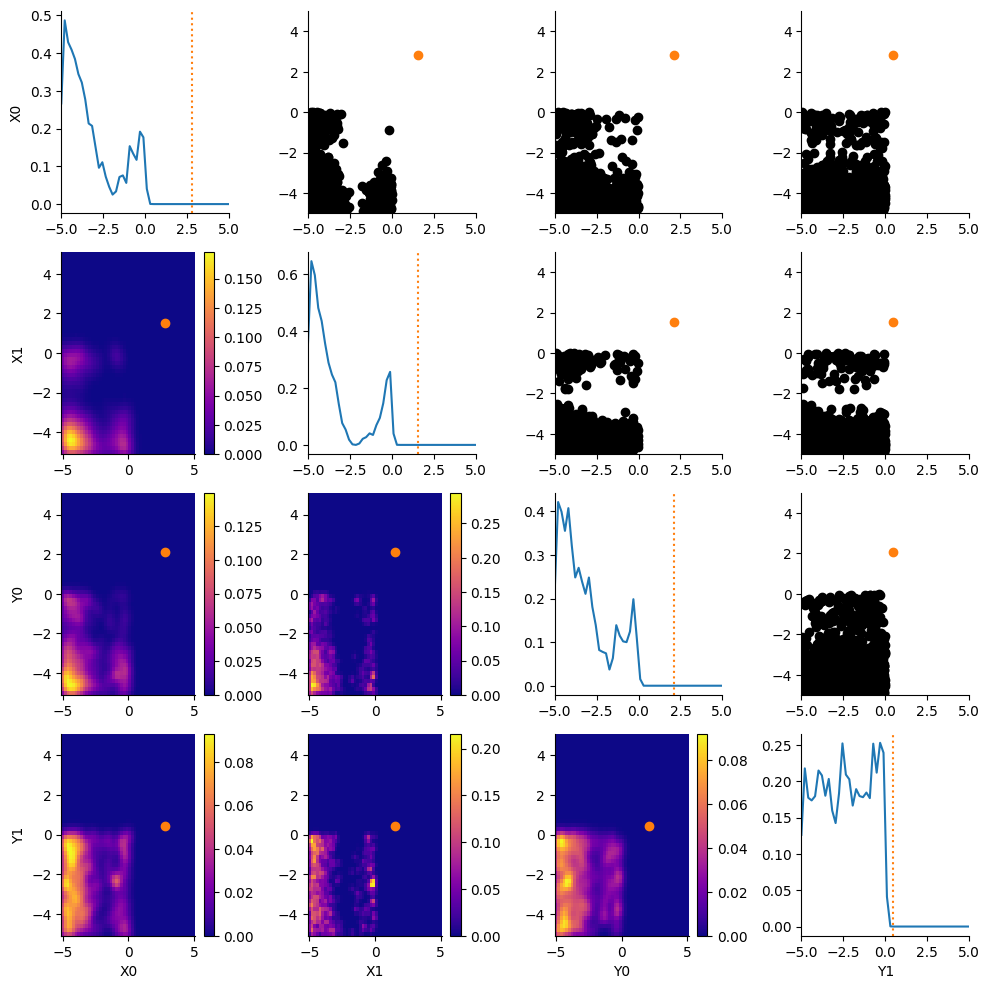

In [10]:
# visualize results
visualization.plot_kde_matrix_highlevel(
    history,
    limits=prior_bounds,
    refval=true_parameters,
    kde=GridSearchCV(),
)

<Axes: xlabel='X0', ylabel='Y0'>

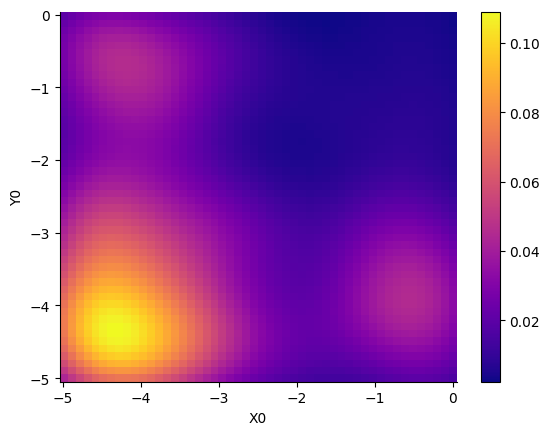

In [11]:
# visualize results of X0 and Y0
visualization.plot_kde_2d_highlevel(
    history,
    x="X0",
    y="Y0",
)

<Axes: xlabel='X1', ylabel='Y1'>

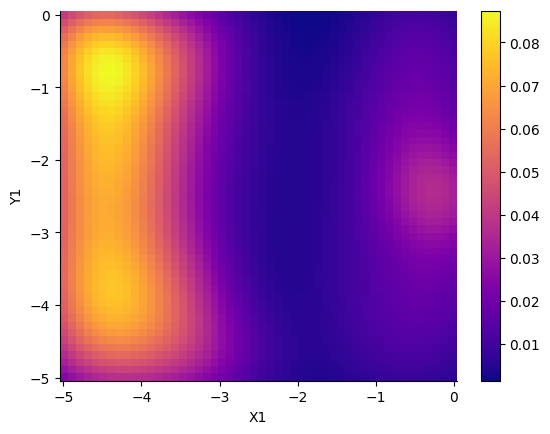

In [12]:
# visualize results of X1 and Y1
visualization.plot_kde_2d_highlevel(
    history,
    x="X1",
    y="Y1",
)